In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim

In [2]:
df = pd.read_csv('/kaggle/input/ham10000-isic2018-raw/dataverse_files/HAM10000_metadata')

In [3]:
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [4]:
import os
kaggle_image_dir = '/kaggle/input/ham10000-isic2018-raw/dataverse_files/HAM10000_images_combined_600x450'
complete_paths = []
for col in df['image_id']:
    col += '.jpg'
    complete_paths.append(os.path.join(kaggle_image_dir, col))
df['full_path'] = complete_paths
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,full_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/kaggle/input/ham10000-isic2018-raw/dataverse_...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/kaggle/input/ham10000-isic2018-raw/dataverse_...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/kaggle/input/ham10000-isic2018-raw/dataverse_...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/kaggle/input/ham10000-isic2018-raw/dataverse_...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/kaggle/input/ham10000-isic2018-raw/dataverse_...


In [5]:
le = LabelEncoder()
df['labels'] = le.fit_transform(df['dx'])

In [6]:
X, y = df['full_path'], df['labels']

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [8]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

In [9]:
from PIL import Image

custom_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

class CustomDataset(Dataset):

    def __init__(self, features, labels, transform):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        img = Image.open(self.features.iloc[index]).convert("RGB")
        img = self.transform(img)
        return img, torch.tensor(self.labels.iloc[index], dtype = torch.long)

In [10]:
train_dataset = CustomDataset(X_train, y_train, custom_transform)
val_dataset = CustomDataset(X_val, y_val, custom_transform)
test_dataset = CustomDataset(X_test, y_test, custom_transform)

In [11]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, pin_memory = True)

In [12]:
class resnet_block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample = None, stride = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1) # padding 1 in 3x3 preserves spatial dimension
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*4, kernel_size = 1, stride = 1, padding = 0)
        self.bn3 = nn.BatchNorm2d(out_channels*4)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, resnet_layers, image_channels, num_classes):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size = 7, stride = 2, padding = 3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        # ResNet layers
        self.layer1 = self._make_layer(block, resnet_layers[0], 64, 1)
        self.layer2 = self._make_layer(block, resnet_layers[1], 128, 2)
        self.layer3 = self._make_layer(block, resnet_layers[2], 256, 2)
        self.layer4 = self._make_layer(block, resnet_layers[3], 512, 2)

        self.fc = nn.Linear(2048, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size = 1, stride = stride),
                                               nn.BatchNorm2d(out_channels * 4))

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [13]:
resnet101 = ResNet(resnet_block, [3, 4, 23, 3], 3, 7)

In [14]:
optimizer = optim.Adam(resnet101.parameters(), lr = 0.00001, weight_decay = 1e-4)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
resnet101.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): resnet_block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
for epoch in range(25):
    resnet101.train()
    total = 0
    correct = 0
    total_val = 0
    correct_val = 0
    total_epoch_loss = 0.0
    total_val_loss = 0.0
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        out = resnet101(batch_features)
        loss = criterion(out, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(out, 1)
        correct += (predicted == batch_labels).sum().item()
        total += batch_labels.shape[0]
        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss/len(train_loader)
    acc = (correct/total)*100.0
    print(f"Epoch: {epoch+1}")
    print(f"Train Loss: {avg_epoch_loss:.4f}")
    print(f"Train Accuracy: {acc:.2f}%")
    train_acc.append(acc)
    train_loss.append(avg_epoch_loss)

    resnet101.eval()
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            out = resnet101(batch_features)
            loss = criterion(out, batch_labels)
            _, predicted = torch.max(out, 1)
            correct_val += (predicted == batch_labels).sum().item()
            total_val += batch_labels.shape[0]
            total_val_loss += loss.item()
        avg_val_loss = total_val_loss/len(val_loader)
        val_acc_epoch = (correct_val/total_val)*100.0
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Val Accuracy: {val_acc_epoch:.2f}%")
        val_acc.append(val_acc_epoch)
        val_loss.append(avg_val_loss)
    print("---")

Epoch: 1
Train Loss: 1.0832
Train Accuracy: 65.49%
Val Loss: 0.9565
Val Accuracy: 67.11%
---
Epoch: 2
Train Loss: 0.9198
Train Accuracy: 67.56%
Val Loss: 0.9007
Val Accuracy: 68.44%
---
Epoch: 3
Train Loss: 0.8625
Train Accuracy: 69.06%
Val Loss: 0.8319
Val Accuracy: 69.64%
---
Epoch: 4
Train Loss: 0.8232
Train Accuracy: 69.99%
Val Loss: 0.8686
Val Accuracy: 68.24%
---
Epoch: 5
Train Loss: 0.8053
Train Accuracy: 70.93%
Val Loss: 0.8383
Val Accuracy: 68.91%
---
Epoch: 6
Train Loss: 0.7960
Train Accuracy: 71.20%
Val Loss: 0.8296
Val Accuracy: 70.17%
---
Epoch: 7
Train Loss: 0.7712
Train Accuracy: 71.61%
Val Loss: 0.8295
Val Accuracy: 70.57%
---
Epoch: 8
Train Loss: 0.7581
Train Accuracy: 71.91%
Val Loss: 0.7601
Val Accuracy: 70.84%
---
Epoch: 9
Train Loss: 0.7343
Train Accuracy: 72.78%
Val Loss: 0.7602
Val Accuracy: 71.30%
---
Epoch: 10
Train Loss: 0.7320
Train Accuracy: 72.95%
Val Loss: 0.7462
Val Accuracy: 72.90%
---
Epoch: 11
Train Loss: 0.7142
Train Accuracy: 73.41%
Val Loss: 0.7919


In [19]:
resnet101.eval()
test_loss = 0.0
total = 0
correct = 0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        out = resnet101(batch_features)
        loss = criterion(out, batch_labels)
        _, predicted = torch.max(out, 1)
        correct += (predicted == batch_labels).sum().item()
        total += batch_labels.shape[0]
        test_loss += loss.item() * batch_labels.shape[0]
    test_acc = (correct/total)*100
    test_loss /= total
print(f"Test Acc: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

Test Acc: 74.18
Test Loss: 0.70


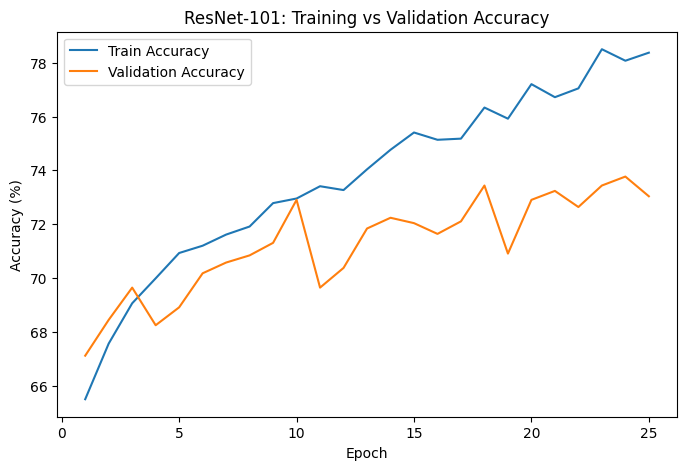

In [20]:
import matplotlib.pyplot as plt

epochs = list(range(1, 26))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("ResNet-101: Training vs Validation Accuracy")
plt.legend()

plt.savefig(
    "/kaggle/working/train_val_accuracy_resnet101.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()
plt.close()

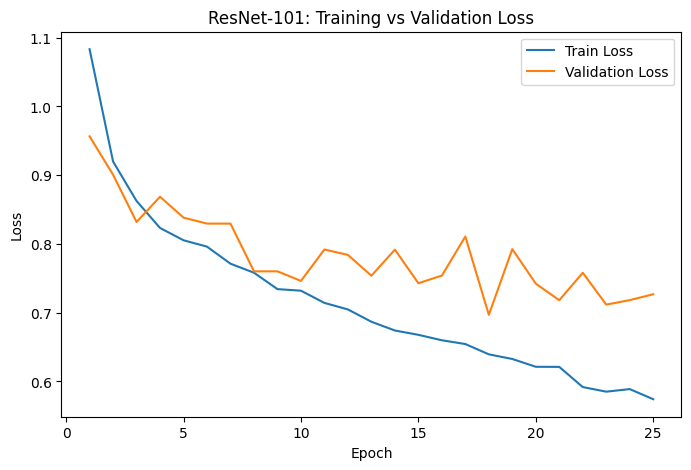

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet-101: Training vs Validation Loss")
plt.legend()

plt.savefig(
    "/kaggle/working/train_val_loss_resnet101.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()
plt.close()